In [91]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import cvxpy as cp

In [2]:
def rk4(x_init: np.ndarray, t_init: float, dt: float, f):
   '''
   Integrates the dynamics of `x_dot = f(x, t)` over a time interval `dt` given an initial state, `x_init`, and time, `t_init`
   using the RK4 algorithm.
   Returns the state at the end of the time interval `dt`.

   - x_init = Initial system state
   - t_init = Initial time
   - dt = Time interval over which `f` is integrated
   - f = f(t, x) - the function representing the time derivative of the state vector, `x`
   '''
   k1 = f(t_init, x_init)
   k2 = f(t_init + dt/2, x_init + dt * k1/2)
   k3 = f(t_init + dt/2, x_init + dt * k2/2)
   k4 = f(t_init + dt, x_init + dt * k3)

   return x_init + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)


In [3]:
def z_dot_dubins(z: np.ndarray, u: np.ndarray):
    '''
    z : [p, theta, alpha]
        distance from goal (polar coord), angle from goal (polar coord), angle between heading and position error vector
        State of dynamical system
    u : [v, w]
        commanded speed, commanded angular velocity
        Control input for dynamical system
    Returns z_dot = f(z, u)
    '''
    z_dot = [u[0] * np.cos(z[2]), -u[0] * np.sin(z[2]) / z[0], -u[1] - u[0] * np.sin(z[2]) / z[0]]
    return np.array(z_dot)

In [4]:
def V_dubins(z: np.ndarray, gamma: float, h: float, k: float):
    '''
    z : [p, theta, alpha]
        distance from goal (polar coord), angle from goal (polar coord), angle between heading and position error vector
        State of dynamical system
    Returns the Lyapunov function of a Dubins vehicle in some state `z`.
    '''
    return 0.5 * gamma * z[0]**2 + 0.5 * (z[2]**2 + h * z[1]**2)

In [5]:
def V_dot_dubins(z: np.ndarray, u: np.ndarray, gamma: float, h: float, k: float):
    return -gamma * z[0]**2 * np.cos(z[2])**2 - k * z[2]**2

In [6]:
def V_grad_dubins(z: np.ndarray, h: float):
    return np.array([z[0], h * z[1], z[2]])

In [7]:
def G_dubins(z: np.ndarray):
    '''
    z : [p, theta, alpha]
        distance from goal (polar coord), angle from goal (polar coord), angle between heading and position error vector
        State of dynamical system
    Dubins can be written as
      z_dot = f(z) + G(z) * u
    with f(z) = 0 and G(z) in R^(3, 2)
    '''
    return np.array([[np.cos(z[2]), 0], [-np.sin(z[2])/z[0], 0], [-np.sin(z[2])/z[0], -1]])

In [80]:
def control_dubins(z: np.ndarray, gamma: float, h: float, k: float, p: float):
    '''
    z : [x, y, theta]
        x_pos, y_pos, orientation
        State of dynamical system
    gamma: exponential stabilization parameter > 0
    h: Lyapunov function parameter > 0
    k: Lyapunov function parameter > 0
    p : slack variable > 0
    '''
    inner_val = np.dot(np.transpose(G_dubins(z)), V_grad_dubins(z, h))

    return -gamma * V_dubins(z, gamma, h, k) * inner_val / (1/p + np.dot(inner_val, inner_val))

In [148]:
def control_dubins_(z: np.ndarray, gamma: float, h: float, k: float, p: float):
    '''
    z : [x, y, theta]
        x_pos, y_pos, orientation
        State of dynamical system
    gamma: exponential stabilization parameter > 0
    h: Lyapunov function parameter > 0
    k: Lyapunov function parameter > 0
    p : slack variable > 0
    '''
    s_min = 1
    a = np.array([1.0, 0.0])
    inner_val = np.dot(np.transpose(G_dubins(z)), V_grad_dubins(z, h))
    F = np.array([[-inner_val[0], 1.0], [-inner_val[1], 0.0], [1.0 / np.sqrt(p), 0.0]])
    mu = -np.linalg.inv(np.transpose(F) @ F) @ np.array([-gamma * V_dubins(z, gamma, h, k), -s_min])

    u = -inner_val * mu[0] + a * mu[1]

    u = control_dubins(z, gamma, h, k, p)

    if (u[0] < s_min):
        u[0] = s_min
        u[1] = -inner_val[1] * (inner_val[0] * s_min + gamma * V_dubins(z, gamma, h, k)) / (inner_val[1]**2 + 1/p)
   
    return u

In [149]:
def control_dubins2(z, gamma, h, k, p):
    
    g = np.array([inner_val[0], inner_val[1], -1.0])
    
    u = cp.Variable(3)
    objective = cp.Minimize(0.5 * cp.quad_form(u, np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, p]])))
    constraints = [g @ u + gamma * V_dubins(z, gamma, h, k) <= 0.0, a @ u >= s_min]
    prob = cp.Problem(objective, constraints)
    prob.solve()

    return u.value

In [150]:
def make_regulated_dubins(gamma: float, h: float, k: float, p: float):
    # f = lambda t, z: z_dot_dubins(z, control_dubins(z, gamma, h, k, p))
    f = lambda t, z: z_dot_dubins(z, control_dubins2(z, gamma, h, k, p))
    return f

In [151]:
# def slack_dubins(z : np.ndarray, gamma: float, p: float):
#     inner_val = np.dot(np.transpose(G_dubins(z)), V_grad_dubins(z, h))
#     if V_dubins(z, z_target, A) < 0.0:
#         return np.zeros(2)
#     return gamma * V_dubins(z, z_target, A) / (1 + p * np.dot(inner_val, inner_val))

In [145]:
def run_experiment(z_init: np.ndarray):
    gamma = 1.
    h = 1.0
    k = 3.0

    p = 100.0
    dt = 0.01
    states = []
    inputs = []
    slacks = []
    states.append(z_init)
    f = make_regulated_dubins(gamma, h, k, p)
    for i in range(3000):
        z = rk4(states[-1], 0.0, dt, f)
        # inputs.append(control_dubins(states[-1], gamma, h, k, p))
        inputs.append(control_dubins2(states[-1], gamma, h, k, p))
        # slacks.append(slack_dubins(states[-1], np.zeros(3), A, 2.0, 1000.))
        states.append(z)
        if (np.linalg.norm(z[0:2]) < 0.001):
            break
    return states, inputs, slacks

In [146]:
init_states = [
    np.array([-1, 1, np.pi/4]),
    np.array([-1, -1, -np.pi/4]),
    np.array([1, 1, 2.9*np.pi/4]),
    np.array([1, -1, -2.9*np.pi/4]),
    np.array([-.8, .3, 2.9*np.pi/4]),
    np.array([-.8, -.3, -2.9*np.pi/4]),
    np.array([.8, .3, 2.9*np.pi/4]),
    np.array([.8, -.3, -2.9*np.pi/4]),
    np.array([0.0, 1.0, 0.0]),
    np.array([0.0, -1.0, 0.0]),
]

trajectories = []
inputs = []

for i, init_state in enumerate(init_states):
    print("exp", i)
    (traj, inp, _) = run_experiment(init_state)
    inputs.append(inp)
    trajectories.append(traj)

exp 0
exp 1
exp 2
exp 3
exp 4
exp 5
exp 6
exp 7
exp 8


/tmp/ipykernel_24660/1920243178.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return np.array([[np.cos(z[2]), 0], [-np.sin(z[2])/z[0], 0], [-np.sin(z[2])/z[0], -1]])


exp 9


In [130]:
def plot_trajectories(trajs: List[np.ndarray]):
    for i, polar_traj in enumerate(trajs):
        traj = [np.array([x[0] * np.cos(x[1]), x[0] * np.sin(x[1]), x[1] - x[2]]) for x in polar_traj]

        pruned_states = [x for i, x in enumerate(traj) if i % 8 == 0]
        pruned_states.append(traj[-1])
        pruned_states.insert(0, traj[0])

        arrows = [[(x[0], x[1]), (x[0] + 0.1 * (1.0 - i / len(pruned_states)) * np.cos(x[2]), x[1] + 0.1 * (1.0 - i / len(pruned_states)) * np.sin(x[2]))] for i, x in enumerate(pruned_states)]
        
        plt.scatter([x[0] for x in pruned_states], [x[1] for x in pruned_states], label="traj " + str(i))
        # plt.plot([x[0] for x in traj], [x[1] for x in traj])
        for arrow in arrows:
            plt.plot([a[0] for a in arrow], [a[1] for a in arrow], color='orange')
    plt.title("trajectories")
    plt.axis("equal")
    plt.legend()
    plt.show()

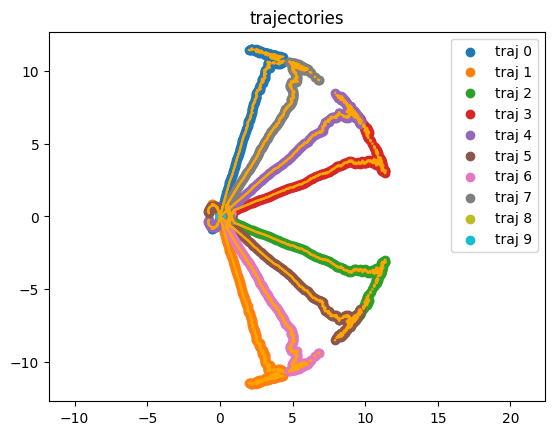

In [131]:
plot_trajectories(trajectories)

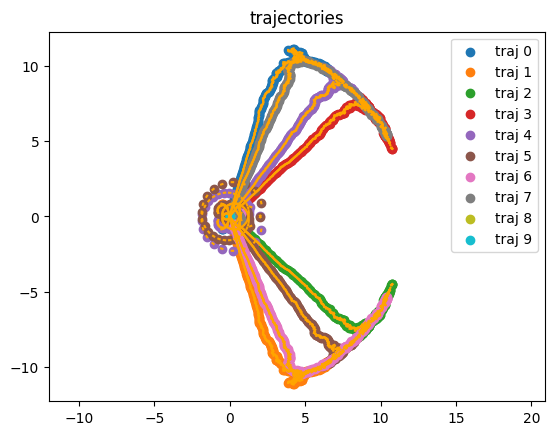

In [147]:
plot_trajectories(trajectories)

In [132]:
def plot_inputs(control_inputs: List[List[np.ndarray]]):
    for i, control_input in enumerate(control_inputs):
        # plt.plot(control_input)
        speeds = [u[0] for u in control_input]
        ang_speeds = [u[1] for u in control_input]
        line, = plt.plot(speeds, label="speed traj " + str(i))
        # plt.plot(ang_speeds, '--', c=line.get_color())

    plt.title("inputs")
    plt.legend()
    plt.show()

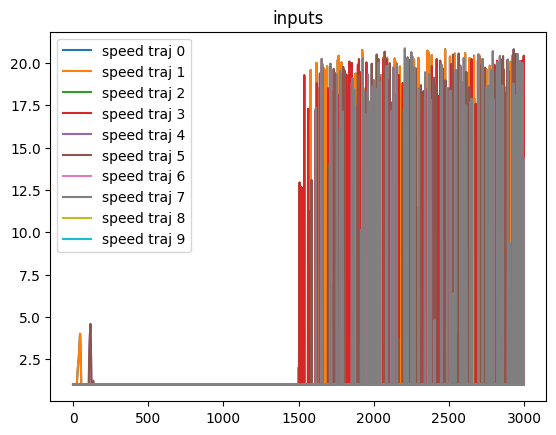

In [133]:
plot_inputs(inputs)